<a href="https://colab.research.google.com/github/AdkSrijan/6CS012_AIML/blob/main/2357636_SrijanAdhikari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection in Tweets Using Recurrent Neural Networks and Their Variants

---

**Submitted by:** Srijan Adhikari  
**University ID:** 2357636


## Environment Setup

In [1]:
# Installation of required libraries
!pip install --upgrade --force-reinstall numpy pandas
!pip install --upgrade scipy
!pip install --upgrade --force-reinstall gensim==4.3.3
!pip install emoji
!pip install gradio -qq


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalli

  Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.

## Required Imports

In [59]:
# Standard library imports
import re
import string
import pickle
from collections import Counter

# NLP and text processing
import nltk
import emoji
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Data manipulation and analysis
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Machine learning and feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Deep learning with Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Word embeddings
import gensim.downloader as api
from gensim.models import KeyedVectors

# GUI imports
import gradio as gr

In [3]:
# NLTK resources for stopword removal and lemmatization
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Mounting Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Text Preprocessing, Tokenization, and Sequence Padding

In [5]:
data = pd.read_csv('/content/drive/MyDrive/AI/Assessment2/sarcastic_headlines.csv')

In [24]:
def text_cleaning_pipeline(text, rule="lemmatize"):
    """Text cleaning pipeline using lemmatization or stemming."""

    text = text.lower()
    text = contractions.fix(text) # Expand contractions
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text) # Remove mentions
    text = re.sub(r"#\w+", "", text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r"[^\w\s]", "", text) # Remove punctuation
    text = re.sub(r"\d+", "", text) # Remove numbers
    tokens = text.split()
    stop_words = set(stopwords.words("english")) # Get English stopwords
    tokens = [word for word in tokens if word not in stop_words] # Remove stopwords
    if rule == "lemmatize":
        lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
        tokens = [lemmatizer.lemmatize(word) for word in tokens] # Lemmatize tokens
    elif rule == "stem":
        stemmer = PorterStemmer() # Initialize stemmer
        tokens = [stemmer.stem(word) for word in tokens] # Stem tokens
    else:
        raise ValueError("Invalid rule. Choose between 'lemmatize' or 'stem'.")
    return " ".join(tokens) # Join tokens back into string


In [8]:
data.columns

Index(['headline', 'is_sarcastic'], dtype='object')

In [9]:
data.shape

(28619, 2)

In [25]:
tqdm.pandas()
# Apply text cleaning to each headline with progress tracking using lemmatization
data['cleaned_text'] = data['headline'].progress_apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize"))

  0%|          | 0/28619 [00:00<?, ?it/s]

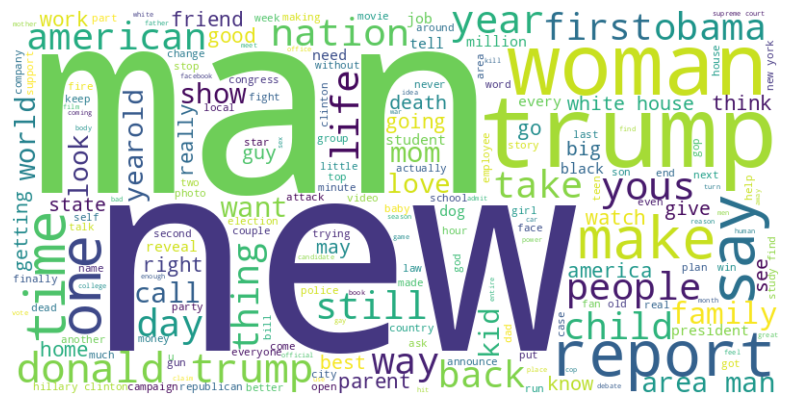

In [26]:
# Combine all cleaned text
text = " ".join(data['cleaned_text'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

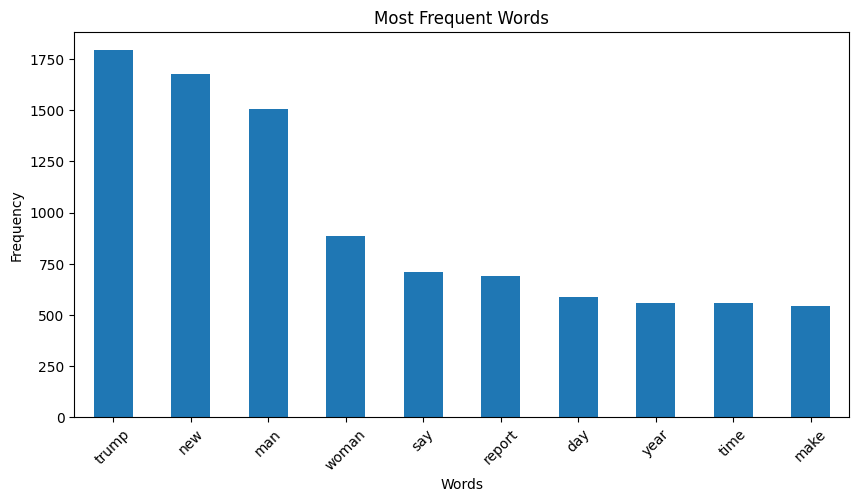

In [27]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(data['cleaned_text'])

# Get the most frequent words and their frequencies
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_count = word_freq.sum(axis=0).sort_values(ascending=False).head(10)

# Plotting
word_count.plot(kind='bar', figsize=(10, 5))
plt.title('Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['is_sarcastic'],
    test_size=0.2,
    random_state=42
)

In [29]:
tokenizer = Tokenizer(num_words=15000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [31]:
save_path = "/content/drive/MyDrive/AI/Assessment2/tokenizer.pickle"
with open(save_path, "wb") as f:
    pickle.dump(tokenizer, f)

seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))
print(f"Max sequence length (95th percentile): {max_len}")

Max sequence length (95th percentile): 11


In [34]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(X_train_pad[:2])  # Display the first two padded sequences

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

[[   2   60  186  608   21 4175   10 1382    0    0    0]
 [3106   62 1382 1325  113  174   57 3107 4731  524    0]]


In [35]:
# Count the word frequencies in dataset
word_counts = Counter(" ".join(data['cleaned_text']).split())
vocab_size = len(word_counts)
print(f" Vocab Size : {vocab_size}")

 Vocab Size : 24983


## Model Building & Training

In [36]:
vocab_size = 15000
embedding_dim = 128

In [37]:
# Model 1: Simple RNN with Trainable Embedding
model1 = Sequential()
model1.add(Embedding(input_dim=15000, output_dim=128, input_length=max_len))  # Embedding layer
model1.add(SimpleRNN(64))  # SimpleRNN layer
model1.add(Dense(1, activation='sigmoid'))  # Output layer

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
# Model 2: LSTM with Trainable Embedding
model2 = Sequential()
model2.add(Embedding(input_dim=15000, output_dim=128, input_length=max_len))  # Embedding layer
model2.add(LSTM(64))  # LSTM layer
model2.add(Dense(1, activation='sigmoid'))  # Output layer

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# LSTM with pretrained Word2Vec embeddings
embedding_model = api.load("word2vec-google-news-300")
embedding_model.save_word2vec_format('/content/drive/MyDrive/AI/Assessment2/word2vec-google-news-300.bin',binary=True) # Saving
model_path = '/content/drive/MyDrive/AI/Assessment2/word2vec-google-news-300.bin'
embedding_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [63]:
embedding_dim = 300  # Dimension of the word vectors
vocab_size = len(tokenizer.word_index) + 1  # Total vocabulary size (+1 for padding token)

embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize embedding matrix with zeros

# Populate embedding matrix with pre-trained vectors
for word, i in tokenizer.word_index.items():
    if word in embedding_model:  # Check if word has a pre-trained embedding
        embedding_vector = embedding_model[word]  # Get the embedding vector
        embedding_matrix[i] = embedding_vector  # Assign it to the corresponding index

In [64]:
model3 = Sequential() # Initialize a sequential model

# Add the embedding layer with pre-trained weights
model3.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=X_train_pad.shape[1],
                    trainable=False))

model3.add(LSTM(64)) # Add an LSTM layer with 64 units to capture sequence dependencies
model3.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


##Model Training and Evaluation

In [42]:
X = data['headline']
y = data['is_sarcastic']

# Convert y to int
y = y.astype(int)

**Model 1**

In [43]:
early_stop_model1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_model1 = model1.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=18,
    batch_size=32,
    callbacks=[early_stop_model1]
)

Epoch 1/18
573/573 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7063 - loss: 0.5537 - val_accuracy: 0.7934 - val_loss: 0.4450
Epoch 2/18
573/573 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9354 - loss: 0.1721 - val_accuracy: 0.7897 - val_loss: 0.5141
Epoch 3/18
573/573 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9824 - loss: 0.0544 - val_accuracy: 0.7718 - val_loss: 0.7706
Epoch 4/18
573/573 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9945 - loss: 0.0201 - val_accuracy: 0.7834 - val_loss: 0.9015
Epoch 5/18
573/573 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9954 - loss: 0.0156 - val_accuracy: 0.7694 - val_loss: 0.9594
Epoch 6/18
573/573 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9963 - loss: 0.0095 - val_accuracy: 0.7733 - val_loss: 1.0164


In [44]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 11, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,797,253 (22.11 MB)

 Trainable params: 1,932,417 (7.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,864,836 (14.74 MB)

In [45]:
model1.save('/content/drive/MyDrive/AI/Assessment2/model1.keras')

**Model 2**

In [46]:
early_stop_model2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_model2 = model2.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop_model2]
)

Epoch 1/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6901 - loss: 0.5592 - val_accuracy: 0.7888 - val_loss: 0.4352
Epoch 2/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8892 - loss: 0.2718 - val_accuracy: 0.7932 - val_loss: 0.4621
Epoch 3/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9401 - loss: 0.1610 - val_accuracy: 0.7901 - val_loss: 0.5498
Epoch 4/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9686 - loss: 0.0852 - val_accuracy: 0.7882 - val_loss: 0.6684
Epoch 5/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9810 - loss: 0.0514 - val_accuracy: 0.7807 - val_loss: 0.8257
Epoch 6/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9891 - loss: 0.0303 - val_accuracy: 0.7799 - val_loss: 0.8899


In [47]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 11, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,908,421 (22.54 MB)

 Trainable params: 1,969,473 (7.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,938,948 (15.03 MB)

In [48]:
model2.save('/content/drive/MyDrive/AI/Assessment2/model2.keras')

**Model 3**

In [49]:
early_stop_model3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_model3 = model3.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stop_model3]
)

Epoch 1/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6929 - loss: 0.5739 - val_accuracy: 0.7668 - val_loss: 0.4826
Epoch 2/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7915 - loss: 0.4435 - val_accuracy: 0.7925 - val_loss: 0.4476
Epoch 3/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8122 - loss: 0.4028 - val_accuracy: 0.7986 - val_loss: 0.4363
Epoch 4/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8440 - loss: 0.3583 - val_accuracy: 0.7973 - val_loss: 0.4548
Epoch 5/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8562 - loss: 0.3255 - val_accuracy: 0.8050 - val_loss: 0.4291
Epoch 6/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8838 - loss: 0.2799 - val_accuracy: 0.8065 - val_loss: 0.4519
Epoch 7/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8973 - loss: 0.2454 - val_accuracy: 0.8063 - val_loss: 0.4698
Epoch 8/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9186 - loss: 0.2053 - val_accuracy: 0.

In [50]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 11, 300)        │     6,740,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,020,617 (26.78 MB)

 Trainable params: 93,505 (365.25 KB)

 Non-trainable params: 6,740,100 (25.71 MB)

 Optimizer params: 187,012 (730.52 KB)

In [51]:
model3.save('/content/drive/MyDrive/AI/Assessment2/model3.keras')

**Visualization**

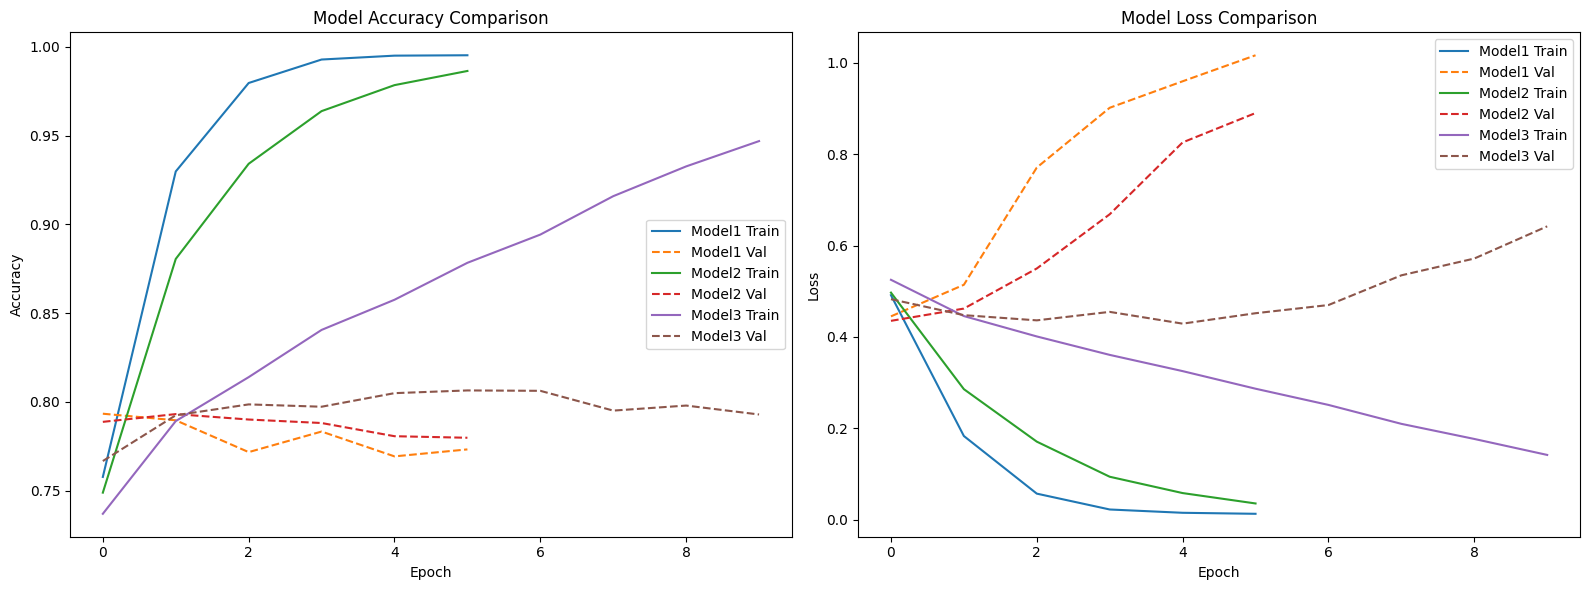

In [52]:
def plot_history(histories, titles):
    plt.figure(figsize=(16, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, titles):
        plt.plot(history.history['accuracy'], label=f'{label} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{label} Val')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss subplot
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, titles):
        plt.plot(history.history['loss'], label=f'{label} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{label} Val')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call with all 3 histories
plot_history(
    histories=[history_model1, history_model2, history_model3],
    titles=["Model1", "Model2", "Model3"]
)


Evaluation

In [53]:
# Evaluate on Test Data
model1_test_loss, model1_test_accuracy = model1.evaluate(X_test_pad, y_test)
model2_test_loss, model2_test_accuracy = model2.evaluate(X_test_pad, y_test)
model3_w2v_test_loss, model3_test_accuracy = model3.evaluate(X_test_pad, y_test)

# Print Test Accuracy for Comparison
print(f"Test Accuracy for RNN: {model1_test_accuracy:.4f}")
print(f"Test Accuracy for LSTM: {model2_test_accuracy:.4f}")
print(f"Test Accuracy for LSTM + Word2Vec: {model3_test_accuracy:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8108 - loss: 0.4154
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8091 - loss: 0.4111
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8172 - loss: 0.3996
Test Accuracy for RNN: 0.8015
Test Accuracy for LSTM: 0.8015
Test Accuracy for LSTM + Word2Vec: 0.8124


In [54]:
# Evaluate models and get predictions
rnn_predictions = model1.predict(X_test_pad)
lstm_predictions = model2.predict(X_test_pad)
lstm_w2v_predictions = model3.predict(X_test_pad)

# Convert predictions to binary
rnn_predictions = (rnn_predictions > 0.5).astype(int)
lstm_predictions = (lstm_predictions > 0.5).astype(int)
lstm_w2v_predictions = (lstm_w2v_predictions > 0.5).astype(int)

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [55]:
# Classification Report for all models
rnn_classification_report = classification_report(y_test, rnn_predictions)
lstm_classification_report = classification_report(y_test, lstm_predictions)
lstm_w2v_classification_report = classification_report(y_test, lstm_w2v_predictions)

# Print Classification Reports for all models
print("RNN Classification Report:\n", rnn_classification_report)
print("LSTM Classification Report:\n", lstm_classification_report)
print("LSTM with Word2Vec Classification Report:\n", lstm_w2v_classification_report)

RNN Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      2995
           1       0.84      0.72      0.78      2729

    accuracy                           0.80      5724
   macro avg       0.81      0.80      0.80      5724
weighted avg       0.81      0.80      0.80      5724

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82      2995
           1       0.81      0.76      0.78      2729

    accuracy                           0.80      5724
   macro avg       0.80      0.80      0.80      5724
weighted avg       0.80      0.80      0.80      5724

LSTM with Word2Vec Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82      2995
           1       0.79      0.82      0.81      2729

    accuracy                           0.81      5724
   macro avg       0.81     

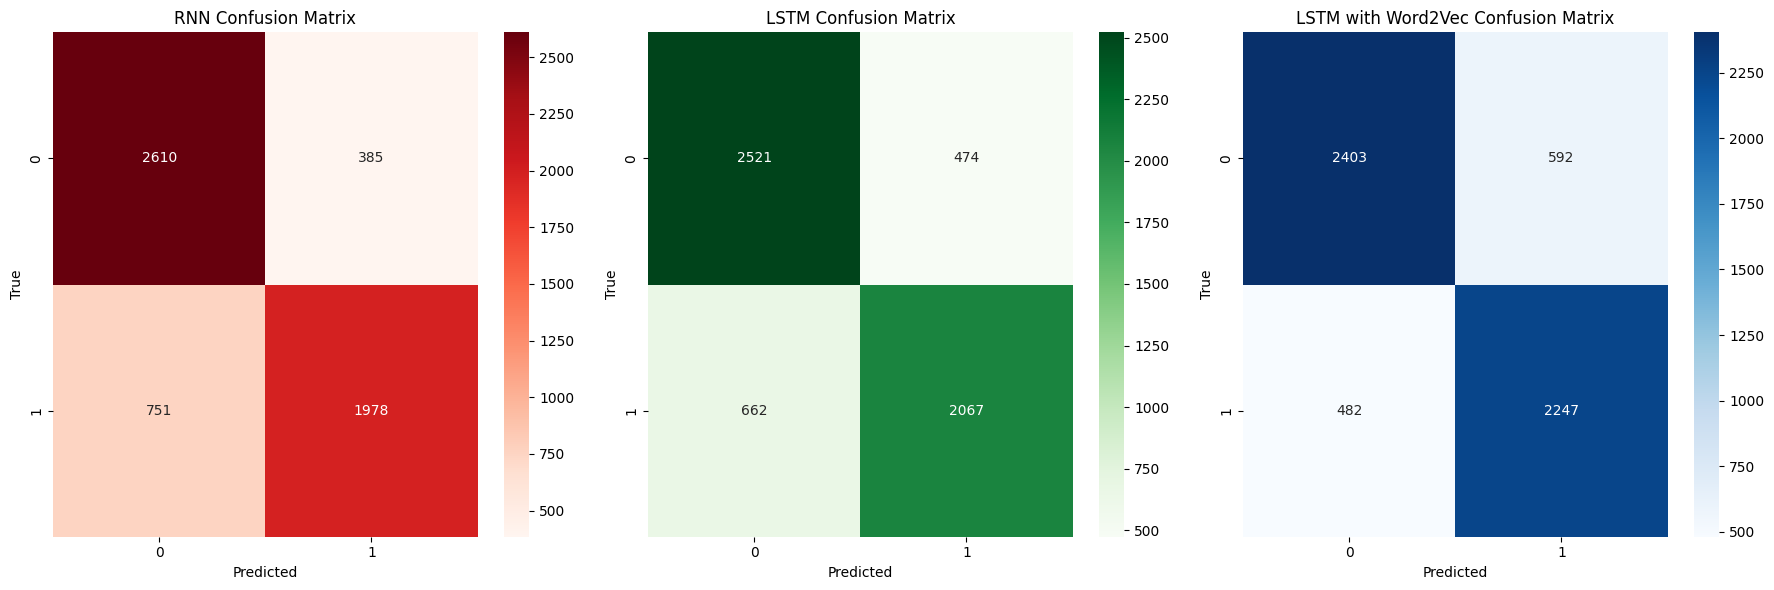

In [56]:
# Confusion Matrix
rnn_conf_matrix = confusion_matrix(y_test, rnn_predictions)
lstm_conf_matrix = confusion_matrix(y_test, lstm_predictions)
lstm_w2v_conf_matrix = confusion_matrix(y_test, lstm_w2v_predictions)

# Confusion Matrix for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RNN Confusion Matrix Plot
sns.heatmap(rnn_conf_matrix, annot=True, fmt="d", cmap="Reds", ax=axes[0])
axes[0].set_title("RNN Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# LSTM Confusion Matrix Plot
sns.heatmap(lstm_conf_matrix, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("LSTM Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# LSTM with Word2Vec Confusion Matrix Plot
sns.heatmap(lstm_w2v_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[2])
axes[2].set_title("LSTM with Word2Vec Confusion Matrix")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("True")

plt.tight_layout()
plt.show()

## GUI for Real Time Prediction:

In [61]:
# Configuration
TOKENIZER_PATH = "/content/drive/MyDrive/AI/Assessment2/tokenizer.pickle"
MODEL_PATHS = {
    "Simple RNN":      "/content/drive/MyDrive/AI/Assessment2/model1.keras",
    "LSTM":             "/content/drive/MyDrive/AI/Assessment2/model2.keras",
    "LSTM w/ Word2Vec": "/content/drive/MyDrive/AI/Assessment2/model3.keras",
}
MAX_LEN     = 11  # use the same maxlen as training
CLASS_NAMES = ["Not Sarcastic","Sarcastic"]  # or actual labels

# Load tokenizer + models
with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

models = {
    name: load_model(path)
    for name, path in MODEL_PATHS.items()
}

# Prediction function
def predict(text, model_name):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    p_arr = models[model_name].predict(pad)[0]
    p = float(p_arr)
    return {
        CLASS_NAMES[0]: 1.0 - p,
        CLASS_NAMES[1]:       p
    }

# Build & launch Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=[
      gr.Textbox(lines=3, placeholder="Type your tweet here…"),
      gr.Dropdown(list(MODEL_PATHS.keys()), value="Simple RNN", label="Choose model")
    ],
    outputs=gr.Label(num_top_classes=len(CLASS_NAMES)),
    title="Sarcasm Detector | 2357636 - Srijan Adhikari",
    description="Paste a tweet and pick a model to see its predictions"
)

iface.launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://657a5fb3d3d4815737.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
